# Solving Maximum Independent Set Problem w/ Evolutionary Algorithm

For this project, I will be applying an evolutionary algorithm to solve/approximate a solution to the maximum independent set problem. I will be using the [**DEAP**](https://github.com/DEAP/deap) library to implement my genetic algorithms and the [**NetworkX**](https://github.com/networkx/networkx) library for graph representation.

## Imports
The first step is to import the required modules needed for this algorithm. If attempting to run this code on your own machine and run into "module not found" errors, you may need to run a `pip install` command for the specified libraries.

- `random` is used for generating random bits, seeding for deterministic randomness, and graph generation
- `math` is used in generating the underlying graphs
- `time` is used to track the running time of algorithms
- `networkx`provides framework for generating and manipulating graph data
- `matplotlib.pyplot` allows us to plot the graphs generated by NetworkX
- `base` provides access to Toolbox and base Fitness
- `creator` is used to create types
- `tools` provides access to genetic operators and other useful methods
- `algorithms` provides access to premade evolutionary loops. (will be implementing custom version, however some methods are still necessary)

In [1]:
import random
import math
import time
import networkx as nx
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

## Creating Underlying Graph
I will now create the underlying graph to be used in the algorithm. To create the graph, I will be using the `nx.random_tree()` function which takes the following parameters:
- `n` [int] The number of nodes in the tree
- `seed` [integer, random_state, or None (default)] Indicator of random number generation state

I use a tree as a base for the graph to ensure that the graph is connected. If any nodes are not connected, then the fitness function will always be biased towards the unconnected nodes. After creating the base for the graph, I create a second graph using the `nx.gnm_random_graph()` function which takes in the following parameters:
- `n` [int] The number of nodes in the graph
- `m` [int] The number of edges
- `seed` [integer, random_state, or None (default)] Indicator of random number generation state
- `directed` [bool, optional (default=False)] If True return a directed graph

The edges from this graph are then added to the original tree to produce a deterministically random connected graph.

### Printing Graphs
The method listed below is a helper function to draw a graph G, with a specified subset of nodes changed to a seperate color. This can be used for any subset of nodes. In this use case, I will be using it to draw independent sets calculated either by exact or approximate algoirhtms.

It is important to note, that when calling nx.spring_layout(G) multiple times for the same graph, it will not always organize nodes in the same fashion on the plane. When comparing results towards the end of the document, graphs may look different but upon inspections, you will see they are structurally the same graph.

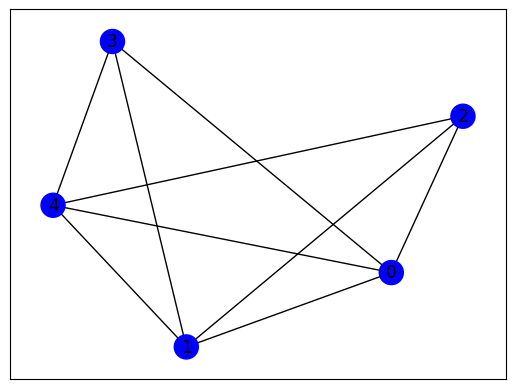

In [2]:
def drawGraph(G, subset):
    # Create dictionary of colors based on set membership
    node_colors = ['red' if node in subset else 'blue' for node in G.nodes()]
    
    # Draw nodes, edges, and labels
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    
    # Display graph
    plt.show()
    
def detRandomGraph(n):
    #Genereate tree as base for final graph
    G = nx.random_tree(n, seed=42)
    
    #Number of edges in addition graph
    k = math.sqrt(n)/2
    
    #Fill in tree with new edges
    G.add_edges_from(nx.gnm_random_graph(n, n-1+k, seed=42).edges())

    #Display the graph
    drawGraph(G, [])
    
    return G

detRandomGraph(5)

## Creating DEAP Required Types
When using the DEAP library, you must create a fitness and individual type. For the MISP, we want to maximize the amount of nodes included in the independent set so we create our `FitnessMax` type with positive weights.

The individual type represents a single solution to the MISP. We will use binary vectors of length n (num_nodes) where a bit of '1' represents membership to the independent set.
> Example: Binary Vector [0, 1, 0, 0, 1] implies a subset of graph G that includes nodes 1 and 4

Naturally, we will use the list data type to represent out individual and assign our `FitnessMax` to the fitness attribute of the `Individual` type.



In [3]:
#Create the individual and fitness types using DEAP creator and create toolbox
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

## Toolbox
After creating our types, the next step is to create our toolbox and register the necessary methods. The goal of the toolbox is to register a standard set of functions under an alias that are to be later used in your algorithms.

In [4]:
#Create toolbox
def createToolbox():
    toolbox = base.Toolbox()
    return toolbox

### Creating Individuals and Populations
We will now register a few functions to the toolbox that will aid in generating individuals and populations in a heirarchical fashion:

- `attr_bool` is used to generate a random binary bit where a bit indicates set membership
- `individual` repeatedly calls `toolbox.attr_bool` to populate a `creator.Individual` type with binary bits
- `population` repeatedly called `toolbox.individual` to create a list of individuals (population)

In [5]:
#Register necessary tools for creating individuals and population to toolbox
def registerIndPop(toolbox, num_nodes):
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, num_nodes)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Fitness Function
The goal of the MISP is to maximize the amount of nodes included in the solution subset. To accomplish this, we need a fitness function that can accurately measure the quality of the solution. For this implementation that uses binary vectors to represent the individual, there are two options for measuring fitness that come to mind:
1. Measure fitness based on number of nodes included in the subset, i.e. the sum of all elements in the vector, and then penalizing the fitness score for infeasible solutions (not an independent set).
2. Before measuring fitness of individual, run it through a repair function that checks to see if the solution is feasible. If it is not, correct the solution, then proceed to measure the fitness via summation.

In this implementation, I will be using the second option. More information will be provided about the repair funtion near it's code's declaration. Below I define the simple fitness function and register it to the toolbox.


In [6]:
#Define fitness function
def evalMIS(individual):
    return sum(individual),

#Register evaluation function to toolbox
def registerFitness(toolbox):
    toolbox.register("evaluate", evalMIS)

### Register Genetic Operators
The next step to using the DEAP library is registering the genetic operators. DEAP provides multiple [**predefined operators**](https://deap.readthedocs.io/en/master/api/tools.html#) for the crossover, mutation, and selection steps. We can register these methods to the toolbox with the appropriate alias.

In [7]:
#Register genetic operators to toolbox
def registerGeneticOperators(toolbox):
    toolbox.register("mate", tools.cxTwoPoint) #crossover
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.10) #mutation
    toolbox.register("select", tools.selTournament, tournsize=3) #selection

### Repair Function: Part 1
Now I will implement the repair function mentioned earlier. Since each individual will be passed into the repair function, we need to check if the individual represents a feasible solution. Here are the primary steps we use to check if a solution is an independent set:
1. Record index of each bit that equals 1 from the individual and store them to list `nodes`. This is so we can reference the correct nodes in the underlying graph.
2. Iterate through each node in `nodes` using a nested for loop to check if there exists an edge between u and v. We use `G.has_edge(u,v)` provided by NetworkX.
3. Check `u != v` to ensure you're not comparing the same node.
4. If there exists an edge between u and v, return `False, nodes`
5. If the solution is feasible, return `True, nodes`

We return nodes, since the indexes will be reused in the repair function and we do not want to recompute the values.

In [8]:
# Function that converts binary representation to NetworkX usable indexes
def getNodeIndexs(individual):
    nodes = []
    i = 0
    for bit in individual:        
        if bit==1:
            nodes.append(i)
        i += 1
        
    return nodes    
    
#Create function to check if an individual represents an independent set
def isIndSet(G, individual):
    #Get indexs of 1's from individual
    nodes = getNodeIndexs(individual)
    
    #Check if node set is independent
    for u in nodes:
        for v in nodes:
            if u != v and G.has_edge(u,v):
                return False, nodes
    return True, nodes   

### Repair Function: Part 2
Next I define the greedy recursive function `repairIndividual` to actually take action on the individuals if need be. The steps of the method are as follows:
1. Check if the individual needs to be repaired by calling `is_ind_set(G, individual)`
2. If the individual is an independent set return. Otherwise, iterate through each node in the subset.
3. Call `G.degree[node]` and compare to the current `max_deg` (highest degree of a node in set).
4. If current node has a higher degree, store the index of the node in `node_to_remove` and update `max_deg`
5. "Remove" `node_to_remove` from the individual by updating the cooresponding bit in the individual to 0
6. Make a recursive calls to `repairIndividual(G, individual)` until the solution is feasible

After defining the repair function, register it to the toolbox under the alias `repair`

In [9]:
#Create function to "repair" non-feasible solutions
def repairIndividual(G, individual):
    #Check to see if individual needs to be repaired
    result, nodes = isIndSet(G, individual)
    if result==True:
        return
    else:
        #Find node in individual with highest degree
        maxDeg = -1
        nodeToRemove = -1
        for node in nodes:
            if G.degree[node] > maxDeg:
                maxDeg = G.degree[node]
                nodeToRemove = node
        #Remove node from individual representation
        individual[nodeToRemove] = 0
        
        #Make recursive calls to repairIndividual until solution is feasible
        repairIndividual(G, individual)
        
#Register repair function to the toolbox
def registerRepair(toolbox):
    toolbox.register("repair", repairIndividual)

## Implement Evolutionary Loop
The DEAP library provides multiple [**predefined algorithms**](https://deap.readthedocs.io/en/master/api/algo.html#complete-algorithms) for executing the evolutionary loop. Since I am implementing the repair function and want to run the repair step mid-loop, I need to either design my own evolutionary loop, or modify the DEAP source code. I've decided to copy the `eaSimple` algorithm from the [**DEAP source code**](https://github.com/DEAP/deap/blob/master/deap/algorithms.py) and modify it.

I've added the repair step after the crossover and mutation steps. This way, individuals can be "repaired" if they are broken during the previous steps and before they are evaluated. The rest of the steps in `eaSimpleWithRepair` are identical to `eaSimple` source code from the DEAP GitHub repository.

In [10]:
#Define genetic algorithm
def eaSimpleWithRepair(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        
        #-------Inserted Repair Step-----------
        for ind in offspring:
            toolbox.repair(G, ind)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

## Define Genetic Algorithm
In `GA()`, I begin by creating our population using the methods registered in the toolbox earlier. After creating the first generation, I run the repair function for each individual before starting the evolutionary loop. This is so that computation time is not wasted on the first generation, as some of the individuals may not be feasible do to random generation.

### Data Collection
The `eaSimpleWithRepair` method takes in a stats object similar to the toolbox. You can register metrics to the stats object that will be measure on each generation of the algorithm. Here I register `avg`, `min`, and `max` that will calculate the average, minimum, and maximum fitness score of each generation respectively.

### Evolutionary Loop
Next I call `eaSimpleRepair` with the following parameters:
- `population`: The initial list of individuals the algorithm starts with
- `toolbox`: The toolbox with all registered methods and genetic operators
- `cxpb`: The probability of mating two individuals
- `mutpb`: The probability of mutating an individual
- `ngen`: The number of generations (stopping condition of evolutionary loop)
- `stats`: The statistics object created previously that will collect data on population fitness values
- `halloffame`: A HallOfFame object that contains the best individuals
- `verbose`: Boolean value that determines if logbook is printed during running or not

### Return Values
This function returns the final population, the logbook, and the HallOfFame object.

In [11]:
#Define the genetic algorithm
def GA(toolbox, G):
    import numpy
    
    #Define initial population of size n
    pop = toolbox.population(n=50)
    
    #Run repair function on population to avoid mis-judging fitness of generation 1
    for ind in pop:
            toolbox.repair(G, ind)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    #Run evolutionary loop
    pop, logbook = eaSimpleWithRepair(pop, toolbox, 
                                      cxpb=0.5, mutpb=0.2, ngen=20,
                                      stats=stats, halloffame=hof, verbose=False)
    
    return pop, logbook, hof

## Exact Algorithm
In graph theory, an independent set of graph G is a clique in the complement of G. Using this knowledge to our advantage, we can write a simple algorithm that finds the exact maximum independent set by finding the clique in the complement with the longest length.

In [12]:
def findMISP(G):
    #Create the complement of G
    GC = nx.complement(G)
    
    #Initialize MISP
    MISP = set()
    
    #Find clique in complement with greatest number of nodes
    for nodes in nx.enumerate_all_cliques(GC):
        if len(nodes) > len(MISP):
            MISP = nodes
    
    #Return binary representation of MISP (same as individual type)
    result = [0] * G.order()
    for i in MISP:
        result[i] = 1
        
    return result
        

### Graphing Log Data
The following code is a helper method to print log data and format it into a readable graph. The purposed is to break down the code into more modular and manageable sections.

In [13]:
def plotLogData(log):
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.show()

## Running the Algorithm
The last step is to run the algorithm on some input graphs. Keeping in mind the structure and execution order of Jupyter Notebooks along with certain DEAP restrictions, all of the code previously written has been placed into methods. This is so that new DEAP environments can be iteratively created based on the problem input. It also allows a user of this notebook to run the entire notebook from top to bottom with no error messages.

========================= Graph of size 5 =========================


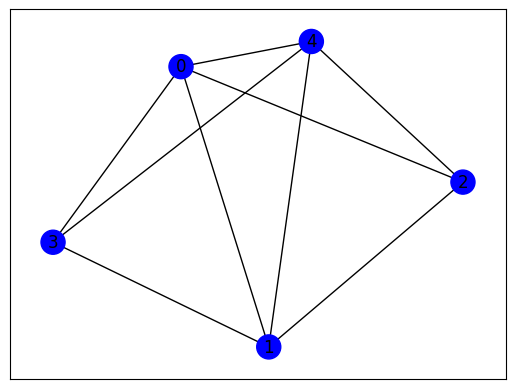

=================== Solution From Exact Algorithm ==================


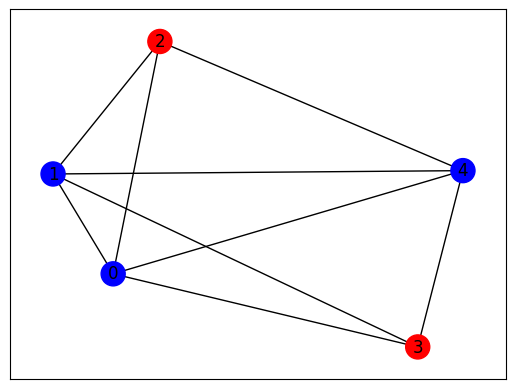

=============== Solution From Evolutionary Algorithm ==============


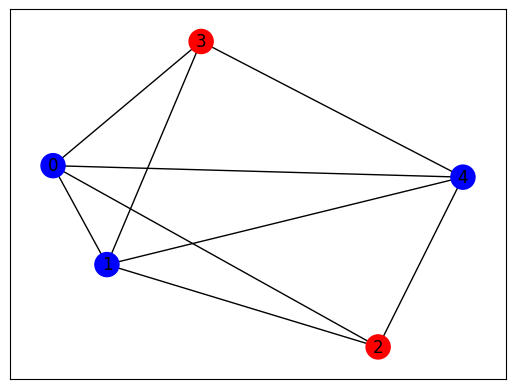

Exact solution is:        [2, 3] with fitness: 2 computed in 0.000
Evolutionary solution is: [2, 3] with fitness: 2 computed in 0.017


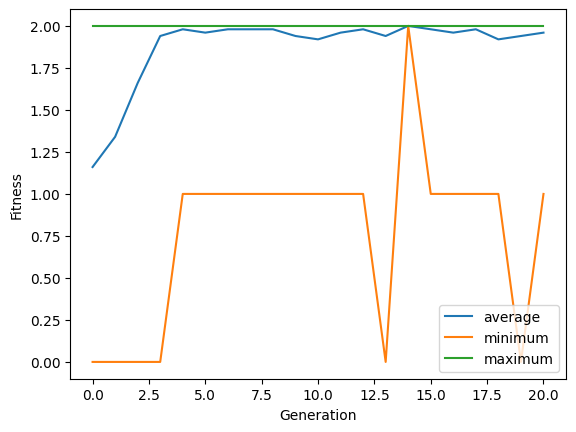

========================= Graph of size 6 =========================


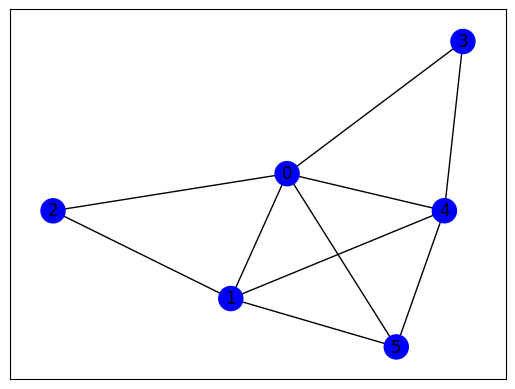

=================== Solution From Exact Algorithm ==================


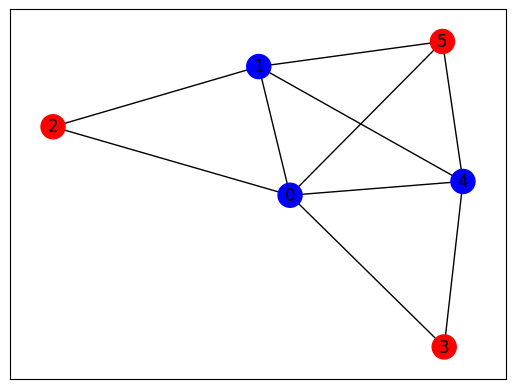

=============== Solution From Evolutionary Algorithm ==============


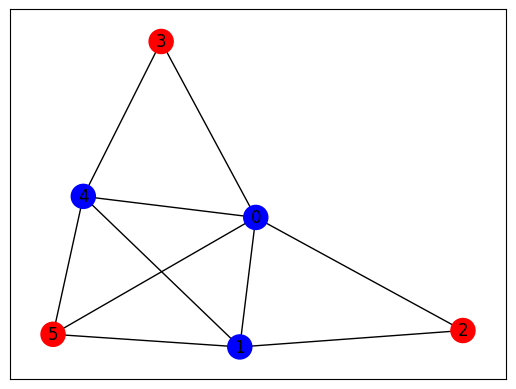

Exact solution is:        [2, 3, 5] with fitness: 3 computed in 0.000
Evolutionary solution is: [2, 3, 5] with fitness: 3 computed in 0.018


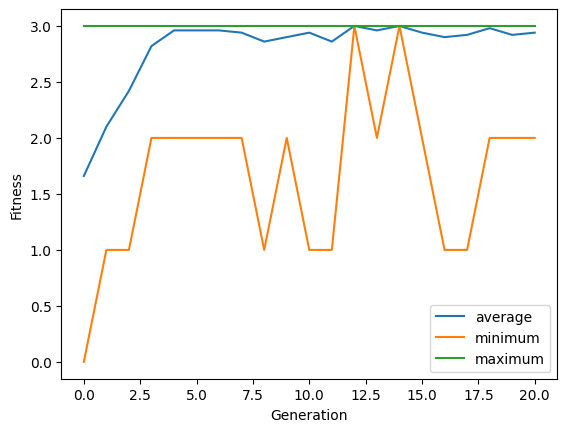

========================= Graph of size 7 =========================


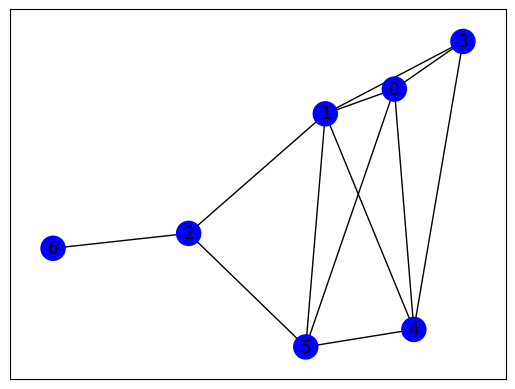

=================== Solution From Exact Algorithm ==================


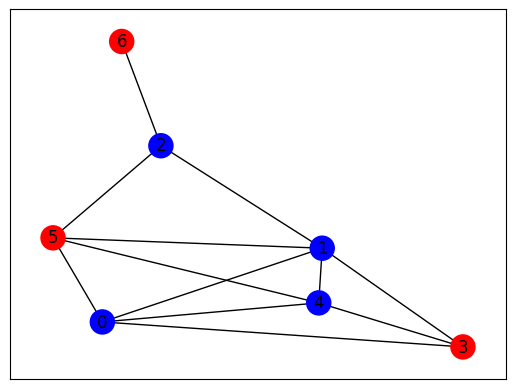

=============== Solution From Evolutionary Algorithm ==============


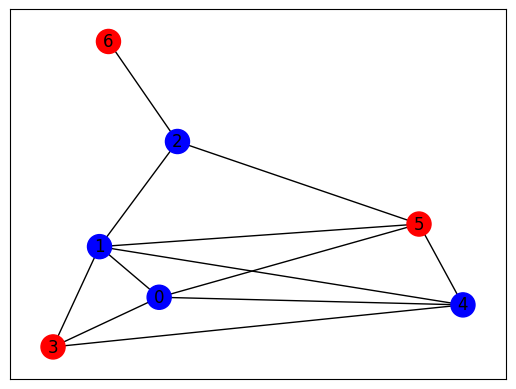

Exact solution is:        [3, 5, 6] with fitness: 3 computed in 0.001
Evolutionary solution is: [3, 5, 6] with fitness: 3 computed in 0.069


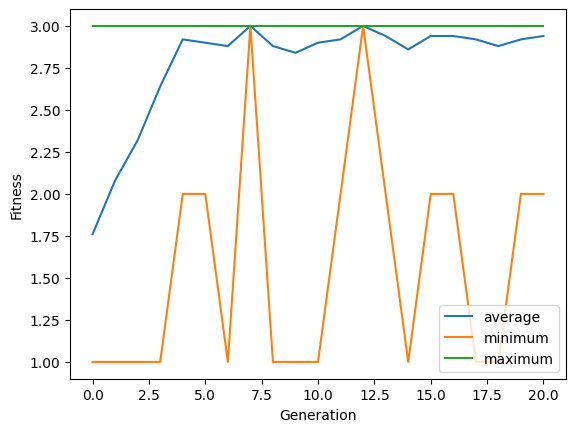

========================= Graph of size 8 =========================


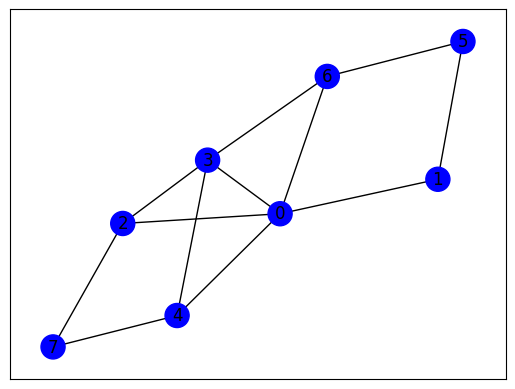

=================== Solution From Exact Algorithm ==================


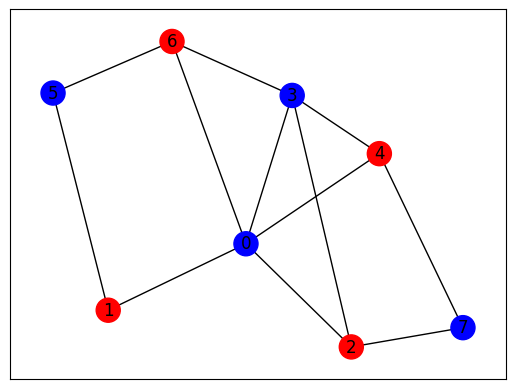

=============== Solution From Evolutionary Algorithm ==============


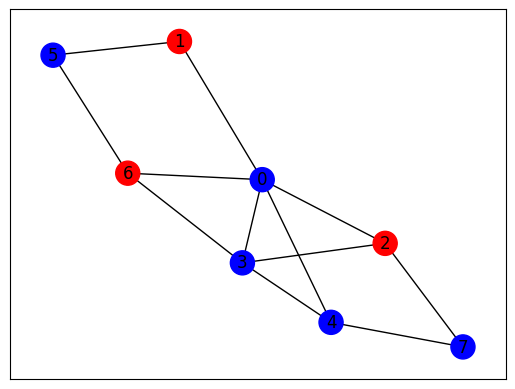

Exact solution is:        [1, 2, 4, 6] with fitness: 4 computed in 0.000
Evolutionary solution is: [1, 2, 6] with fitness: 3 computed in 0.019


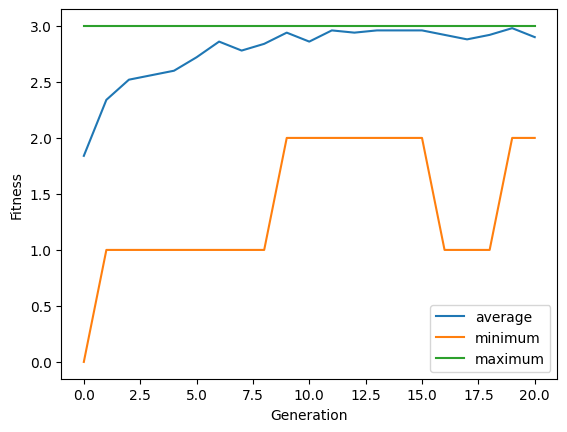

========================= Graph of size 9 =========================


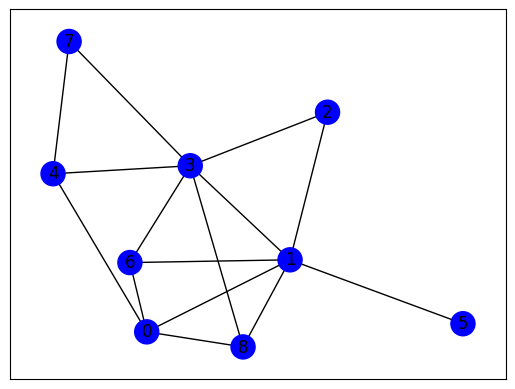

=================== Solution From Exact Algorithm ==================


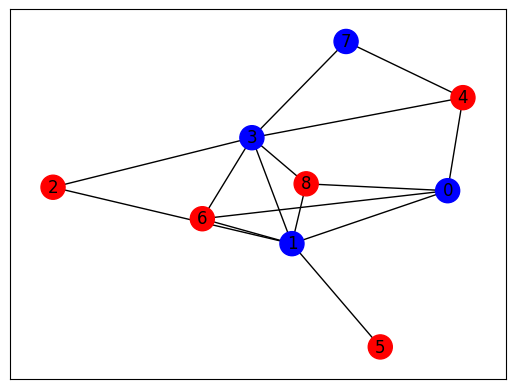

=============== Solution From Evolutionary Algorithm ==============


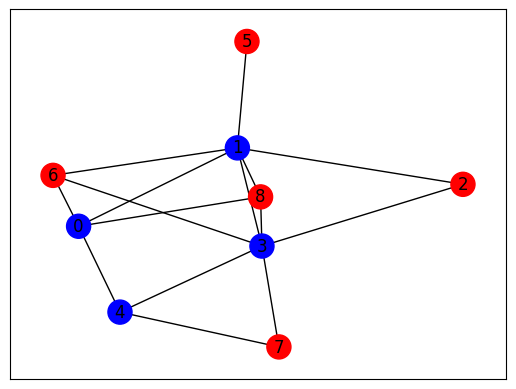

Exact solution is:        [2, 4, 5, 6, 8] with fitness: 5 computed in 0.000
Evolutionary solution is: [2, 5, 6, 7, 8] with fitness: 5 computed in 0.022


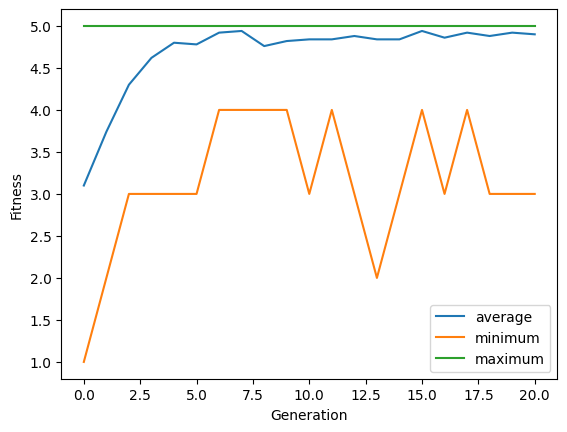

========================= Graph of size 10 =========================


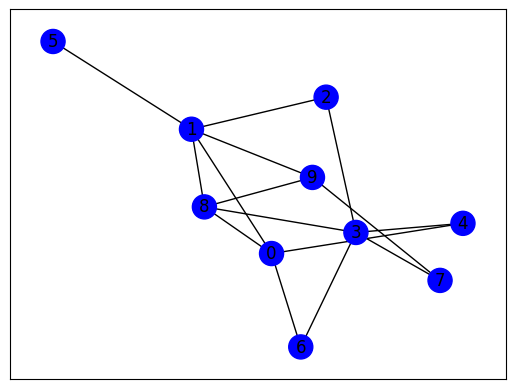

=================== Solution From Exact Algorithm ==================


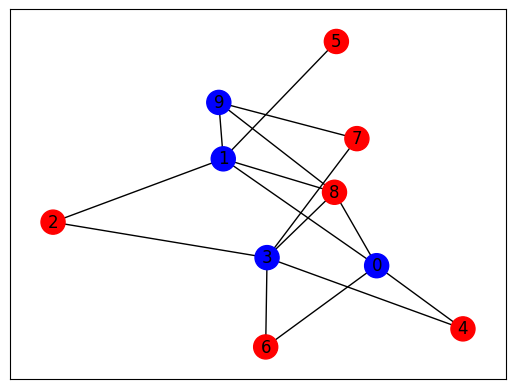

=============== Solution From Evolutionary Algorithm ==============


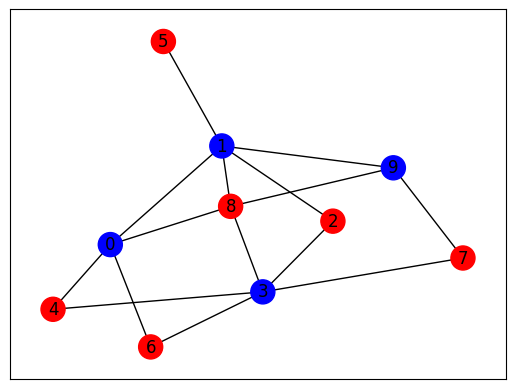

Exact solution is:        [2, 4, 5, 6, 7, 8] with fitness: 6 computed in 0.000
Evolutionary solution is: [2, 4, 5, 6, 7, 8] with fitness: 6 computed in 0.023


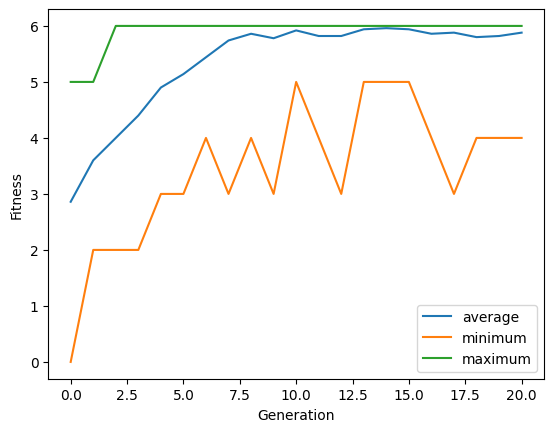

  Computation Values for Exact Algorithm               Computation Values for Evolutionary Algorithm
------------------------------------------------------------------------------------------------------------
   5 nodes | 0.000 seconds | fitness: 2                  5 nodes | 0.017 seconds | fitness: 2
   6 nodes | 0.000 seconds | fitness: 3                  6 nodes | 0.018 seconds | fitness: 3
   7 nodes | 0.001 seconds | fitness: 3                  7 nodes | 0.069 seconds | fitness: 3
   8 nodes | 0.000 seconds | fitness: 4                  8 nodes | 0.019 seconds | fitness: 3
   9 nodes | 0.000 seconds | fitness: 5                  9 nodes | 0.022 seconds | fitness: 5
   10 nodes | 0.000 seconds | fitness: 6                  10 nodes | 0.023 seconds | fitness: 6


In [14]:
if __name__ == "__main__":
    
    #Define two dictionaries used for displaying results 
    exact_computations = {}
    evolutionary_computations = {}
    
    for n in range(5, 11):
        #Generate underlying deterministic random graph
        print("========================= Graph of size %s =========================" % (n))
        G = detRandomGraph(n)
        
        # Running Exact Algorithm on G
        print("=================== Solution From Exact Algorithm ==================")
        exact_t0 = time.time()
        rawExactSolution = findMISP(G)
        exact_t1 = time.time()
        exact_time = exact_t1 - exact_t0
        
        exactSolution = getNodeIndexs(rawExactSolution)
        exact_computations.update({"{}".format(n) : (exact_time, len(exactSolution))})
        drawGraph(G, exactSolution)
        
        # Running Evolutionary Algorithm on G
        print("=============== Solution From Evolutionary Algorithm ==============")
        
        #Create toolbox and register all methods
        toolbox = createToolbox()
        registerIndPop(toolbox, n)
        registerFitness(toolbox)
        registerGeneticOperators(toolbox)
        registerRepair(toolbox)
    
        #Run algorithm on graph G
        evolutionary_t0 = time.time()
        pop, log, hof = GA(toolbox, G)
        evolutionary_t1 = time.time()
        evolutionary_time = evolutionary_t1 - evolutionary_t0
        
        evolutionarySolution = getNodeIndexs(hof[0])
        evolutionary_computations.update({"{}".format(n) : (evolutionary_time, len(evolutionarySolution))})
        drawGraph(G, evolutionarySolution)
        
        # Display results
        print("Exact solution is:        {} with fitness: {} computed in {:.3f}".format(exactSolution,
                                                                                 len(exactSolution),
                                                                                 exact_time))
        print("Evolutionary solution is: {} with fitness: {} computed in {:.3f}".format(evolutionarySolution,
                                                                                        len(evolutionarySolution),
                                                                                        evolutionary_time))
        #Display plot of log data from evolutionary algorithm run
        plotLogData(log)
    
    #Print out data from dictionaries side by side for comparison
    print("  Computation Values for Exact Algorithm               Computation Values for Evolutionary Algorithm")
    print("------------------------------------------------------------------------------------------------------------") 
    for (n_1, values_1), (n_2, values_2) in zip(exact_computations.items(), evolutionary_computations.items()):
        print("   {} nodes | {:.3f} seconds | fitness: {}               ".format(n_1, values_1[0], values_1[1]) +
              "   {} nodes | {:.3f} seconds | fitness: {}".format(n_2, values_2[0], values_2[1]))

